In [1]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_rows", None)  # 모든 행 출력
pd.set_option("display.max_columns", None)  # 모든 열 출력
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios, plot_summary)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 5개 파일을 불러왔습니다: 1201.csv, 137.csv, 401.csv, 524.csv, 89.csv
📊 데이터 Shape: I=5, T=24, S=20
✅ 시뮬레이션 초기화 완료: S=20, Randomness='high', M1=757.00, M2=2111.00


### 모두 포함 최적화 (holistic aggregation)

In [2]:
set = gp.Model("set")
set.setParam("MIPGap", 1e-7)
set.setParam("OutputFlag", 0)

x = set.addVars(I, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
ep = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_plus")
em = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_minus")

yp = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
z = set.addVars(I, T + 1, S, vtype=GRB.CONTINUOUS, name="z")
zc = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
zd = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
d = set.addVars(I, I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")

p1 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p1")
p2 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p2")
p3 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p3")
p4 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p4")

set.update()

obj = gp.quicksum(P_DA[t] * gp.quicksum(x[i, t] for i in range(I)) for t in range(T)) + gp.quicksum((1 / S) * (P_RT[t, s] * gp.quicksum(ep[i, t, s] for i in range(I)) - P_PN[t] * gp.quicksum(em[i, t, s] for i in range(I))) for t in range(T) for s in range(S))

set.setObjective(obj, GRB.MAXIMIZE)

for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
    set.addConstr(yp[i, t, s] + zc[i, t, s] <= R[i, t, s] + zd[i, t, s])
    set.addConstr(zd[i, t, s] <= z[i, t, s])
    set.addConstr(zc[i, t, s] <= K[i] - z[i, t, s])
    set.addConstr(yp[i, t, s] <= M1 * p3[i, t, s])
    set.addConstr(ym[i, t, s] <= M1 * (1 - p3[i, t, s]))
    set.addConstr(ym[i, t, s] <= M1 * p2[i, t, s])
    set.addConstr(zc[i, t, s] <= M1 * (1 - p2[i, t, s]))
    set.addConstr(zc[i, t, s] <= M1 * p1[i, t, s])
    set.addConstr(zd[i, t, s] <= M1 * (1 - p1[i, t, s]))
    set.addConstr(z[i, t, s] <= K[i])
    set.addConstr(z[i, t + 1, s] == z[i, t, s] + zc[i, t, s] - zd[i, t, s])
for i, s in product(range(I), range(S)):
    set.addConstr(z[i, 0, s] == K0[i])

for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(ep[i, t, s] == yp[i, t, s] - gp.quicksum(d[i, j, t, s] for j in range(I)))
    set.addConstr(em[i, t, s] == ym[i, t, s] - gp.quicksum(d[j, i, t, s] for j in range(I)))
    set.addConstr(gp.quicksum(ep[i, t, s] for i in range(I)) <= M2 * p4[i, t, s])
    set.addConstr(gp.quicksum(em[i, t, s] for i in range(I)) <= M2 * (1 - p4[i, t, s]))
    set.addConstr(d[i, i, t, s] == 0)

set.optimize()

if set.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {set.objVal}")
else:
    print("No optimal solution found.")
    
x_opt = np.array([[x[i, t].X for t in range(T)] for i in range(I)])
a_opt = np.sum(x_opt, axis=0)
yp_opt = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)]) 
ym_opt = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
z_opt = np.array([[[z[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zc_opt = np.array([[[zc[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zd_opt = np.array([[[zd[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
ep_opt = np.array([[[ep[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
bp_opt = np.sum(ep_opt, axis=0) 
em_opt = np.array([[[em[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
bm_opt = np.sum(em_opt, axis=0) 
d_opt = np.array([[[[d[i, j, t, s].x for s in range(S)] for t in range(T)] for j in range(I)] for i in range(I)])
dp_opt = np.sum(d_opt, axis=1)
dm_opt = np.sum(d_opt, axis=0)

Set parameter Username
Set parameter LicenseID to value 2681721
Academic license - for non-commercial use only - expires 2026-06-24
Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13900K, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 40900 rows, 38620 columns and 134500 nonzeros
Model fingerprint: 0x669a2df2
Variable types: 29020 continuous, 9600 integer (9600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [2e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 20547 rows and 16054 columns
Presolve time: 0.14s
Presolved: 20353 rows, 22566 columns, 67441 nonzeros
Variable types: 17627 continuous, 4939 integer (4939 binary)
Found heuristic solution: objective 967948.08208


### target_i 제외 최적화

In [3]:
def optimize_without(target_i, R, K, K0, P_DA, P_RT, P_PN, I, T, S):
    I_set = [i for i in range(I) if i != target_i]
    M1 = np.maximum(R[I_set], K[I_set, None, None]).max()
    M2 = max(R[I_set].sum(axis=0).max(), K[I_set].sum())

    model = gp.Model(f"set_without_{target_i}")
    model.setParam("MIPGap", 1e-7)
    model.setParam("OutputFlag", 0)

    x = model.addVars(I_set, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
    ep = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="e_plus")
    em = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="e_minus")
    yp = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
    ym = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
    z = model.addVars(I_set, T + 1, S, vtype=GRB.CONTINUOUS, name="z")
    zc = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
    zd = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
    d = model.addVars(I_set, I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")

    p1 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p1")
    p2 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p2")
    p3 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p3")
    p4 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p4")

    obj = gp.quicksum(P_DA[t] * x[i, t] for i in I_set for t in range(T)) + gp.quicksum(
        (1 / S) * (
            P_RT[t, s] * gp.quicksum(ep[i, t, s] for i in I_set) -
            P_PN[t] * gp.quicksum(em[i, t, s] for i in I_set)
        )
        for t in range(T) for s in range(S)
    )
    model.setObjective(obj, GRB.MAXIMIZE)

    for i, t, s in product(I_set, range(T), range(S)):
        model.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
        model.addConstr(yp[i, t, s] + zc[i, t, s] <= R[i, t, s] + zd[i, t, s])
        model.addConstr(zd[i, t, s] <= z[i, t, s])
        model.addConstr(zc[i, t, s] <= K[i] - z[i, t, s])
        model.addConstr(yp[i, t, s] <= M1 * p3[i, t, s])
        model.addConstr(ym[i, t, s] <= M1 * (1 - p3[i, t, s]))
        model.addConstr(ym[i, t, s] <= M1 * p2[i, t, s])
        model.addConstr(zc[i, t, s] <= M1 * (1 - p2[i, t, s]))
        model.addConstr(zc[i, t, s] <= M1 * p1[i, t, s])
        model.addConstr(zd[i, t, s] <= M1 * (1 - p1[i, t, s]))
        model.addConstr(z[i, t, s] <= K[i])
        model.addConstr(z[i, t + 1, s] == z[i, t, s] + zc[i, t, s] - zd[i, t, s])

    for i, s in product(I_set, range(S)):
        model.addConstr(z[i, 0, s] == K0[i])

    for i, t, s in product(I_set, range(T), range(S)):
        model.addConstr(ep[i, t, s] == yp[i, t, s] - gp.quicksum(d[i, j, t, s] for j in I_set if j != i))
        model.addConstr(em[i, t, s] == ym[i, t, s] - gp.quicksum(d[j, i, t, s] for j in I_set if j != i))
        model.addConstr(gp.quicksum(ep[i, t, s] for i in I_set) <= M2 * p4[i, t, s])
        model.addConstr(gp.quicksum(em[i, t, s] for i in I_set) <= M2 * (1 - p4[i, t, s]))
        model.addConstr(d[i, i, t, s] == 0)

    model.optimize()

    i_map = {i: idx for idx, i in enumerate(I_set)}

    x_vals = np.array([[x[i, t].X for t in range(T)] for i in I_set])
    ep_vals = np.array([[[ep[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
    em_vals = np.array([[[em[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
    yp_vals = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
    ym_vals = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
    d_vals = np.array([[[[d[i, j, t, s].X for s in range(S)] for t in range(T)] for j in I_set] for i in I_set])
    dp_vals = np.sum(d_vals, axis=1)
    dm_vals = np.sum(d_vals, axis=0)

    return x_vals, ep_vals, em_vals, yp_vals, ym_vals, d_vals, dp_vals, dm_vals, i_map

In [4]:
def optimize_without_forall(R, K, K0, P_DA, P_RT, P_PN, I, T, S):
    x_without = {}; ep_without = {}; em_without = {}
    yp_without = {}; ym_without = {}; d_without = {}; dp_without = {}; dm_without = {}; i_map_without = {}

    for target_i in tqdm(range(I), desc="Solving settlement model for each target DER"):
        x_vals, ep_vals, em_vals, yp_vals, ym_vals, d_vals,  dp_vals, dm_vals, i_map = optimize_without(
            target_i, R, K, K0, P_DA, P_RT, P_PN, I, T, S
        )
        x_without[target_i] = x_vals
        ep_without[target_i] = ep_vals
        em_without[target_i] = em_vals
        yp_without[target_i] = yp_vals
        ym_without[target_i] = ym_vals
        d_without[target_i] = d_vals
        dp_without[target_i] = dp_vals
        dm_without[target_i] = dm_vals
        i_map_without[target_i] = i_map

    return x_without, ep_without, em_without, yp_without, ym_without, d_without, dp_without, dm_without, i_map_without

In [5]:
x_without, ep_without, em_without, yp_without, ym_without, d_without, dp_without, dm_without, i_map_without = optimize_without_forall(R, K, K0, P_DA, P_RT, P_PN, I, T, S)

Solving settlement model for each target DER:   0%|          | 0/5 [00:00<?, ?it/s]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  20%|██        | 1/5 [00:11<00:46, 11.72s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  40%|████      | 2/5 [00:19<00:28,  9.64s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  60%|██████    | 3/5 [00:23<00:13,  6.80s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER:  80%|████████  | 4/5 [00:30<00:07,  7.14s/it]

Set parameter MIPGap to value 1e-07


Solving settlement model for each target DER: 100%|██████████| 5/5 [00:51<00:00, 10.34s/it]


### price functions

In [6]:
def compute_price_functions(
    yp_without, ym_without, dp_without, dm_without, i_map_without,
    P_RT, P_PN, T, S, I
):
    rdc_coefficients_all = np.full((I, T, S, 2), np.nan)
    rsc_coefficients_all = np.full((I, T, S, 2), np.nan)
    rho_plus_func_all = np.full((I, T, S, 2), np.nan)   # RDC
    rho_minus_func_all = np.full((I, T, S, 2), np.nan)  # RSC
    
    total_demand_without = np.zeros((I, T, S))
    total_supply_without = np.zeros((I, T, S))

    for target_i in range(I):
        yp_vals = yp_without[target_i]
        ym_vals = ym_without[target_i]
        dp_vals = dp_without[target_i]
        dm_vals = dm_without[target_i]
        i_map = i_map_without[target_i]

        for t in range(T):
            for s in range(S):
                total_supply = sum(yp_vals[i_map[i], t, s] for i in i_map)
                total_demand = sum(ym_vals[i_map[i], t, s] for i in i_map)
                
                total_supply_without[target_i, t, s] = total_supply
                total_demand_without[target_i, t, s] = total_demand

                given_profit = received_profit = realized_supply = realized_demand = 0

                for i in i_map:
                    given_profit += dp_vals[i, t, s] * P_PN[t]
                    received_profit += dm_vals[i, t, s] * P_RT[t, s]
                    realized_supply += dp_vals[i, t, s]
                    realized_demand += dm_vals[i, t, s]

                BIG_M_POS = 1e10
                BIG_M_NEG = -1e10

                if realized_demand <= 1e-4 or realized_supply <= 1e-4:
                    rho_plus_func_all[target_i, t, s, :] = [BIG_M_NEG, 0.0]
                    rho_minus_func_all[target_i, t, s, :] = [BIG_M_POS, 0.0]
                    continue

                a_d = P_PN[t]
                b_d = 2 * (a_d * realized_demand - received_profit) / (realized_demand ** 2)
                a_s = P_RT[t, s]
                b_s = 2 * (given_profit - a_s * realized_supply) / (realized_supply ** 2)

                denom = b_d + b_s
                if abs(denom) < 1e-6: continue

                # === RDC: q0 → 공급 증가 ===
                q0_list_rdc = np.linspace(-5, 1.1 * total_supply, 10)
                prices_rdc = []
                for q0 in q0_list_rdc:
                    q_cleared = (a_d - a_s + b_s * q0) / denom
                    p_cleared = a_d - b_d * q_cleared
                    prices_rdc.append(p_cleared)
                q_rdc = np.array(q0_list_rdc).reshape(-1, 1)
                p_rdc = np.array(prices_rdc)

                # === RSC: q0 → 수요 증가 ===
                q0_list_rsc = np.linspace(-5, 1.1 * total_demand, 10)
                prices_rsc = []
                for q0 in q0_list_rsc:
                    q_cleared = (a_d + b_d * q0 - a_s) / denom
                    p_cleared = a_s + b_s * q_cleared
                    prices_rsc.append(p_cleared)
                q_rsc = np.array(q0_list_rsc).reshape(-1, 1)
                p_rsc = np.array(prices_rsc)

                # 선형 회귀 근사 (1차)
                X_poly_rdc = PolynomialFeatures(degree=1).fit_transform(q_rdc)
                X_poly_rsc = PolynomialFeatures(degree=1).fit_transform(q_rsc)

                model_rdc = LinearRegression().fit(X_poly_rdc, p_rdc)
                model_rsc = LinearRegression().fit(X_poly_rsc, p_rsc)

                a_rdc, b_rdc = model_rdc.intercept_, model_rdc.coef_[1]
                a_rsc, b_rsc = model_rsc.intercept_, model_rsc.coef_[1]

                rho_plus_func_all[target_i, t, s, :] = [a_rdc, b_rdc]
                rho_minus_func_all[target_i, t, s, :] = [a_rsc, b_rsc]
                rdc_coefficients_all[target_i, t, s, :] = [a_rdc, b_rdc]
                rsc_coefficients_all[target_i, t, s, :] = [a_rsc, b_rsc]

    return rdc_coefficients_all, rsc_coefficients_all, rho_plus_func_all, rho_minus_func_all, total_demand_without, total_supply_without

In [7]:
rdc, rsc, rho_plus, rho_minus, total_demand_wihout, total_supply_without = compute_price_functions(
    yp_without, ym_without, dp_without, dm_without, i_map_without,
    P_RT, P_PN, T, S, I
)

In [8]:
# 인덱스 설정
target_i = 0
t = 20
s = 5

# 가격 함수 계수 추출
ap, bp = rho_plus[target_i, t, s, :]
am, bm = rho_minus[target_i, t, s, :]

print(f"ρ⁺(d) = {ap:.2f} + {bp:.2f}·d")
print(f"ρ⁻(d) = {am:.2f} + {bm:.2f}·d")

ρ⁺(d) = 132.96 + -1.98·d
ρ⁻(d) = 132.96 + 1.98·d


### transfrom pwl

In [9]:
def transform_step(rho_plus, rho_minus, total_demand_without, total_supply_without):

    I, T, S, _ = rho_plus.shape
    rho_plus_piece = np.full((I, T, S), np.nan, dtype=object)
    rho_minus_piece = np.full((I, T, S), np.nan, dtype=object)

    B_map_plus = np.zeros((I, T, S), dtype=int)
    B_map_minus = np.zeros((I, T, S), dtype=int)

    for target_i, t, s in product(range(I), range(T), range(S)):
        # ➤ RDC 
        ap, bp = rho_plus[target_i, t, s]  
        Bp = max(1, int(np.ceil(total_supply_without[target_i, t, s])))

        if total_supply_without[target_i, t, s] <= 0:
            rho_plus_piece[target_i][t][s] = np.array([[0, ap + bp * 0]])
            B_map_plus[target_i, t, s] = 1
        else:
            qp_org = np.linspace(0, total_supply_without[target_i, t, s], Bp)
            step_width = total_supply_without[target_i, t, s] / Bp
            qp_bound = np.linspace(-step_width/2, total_supply_without[target_i, t, s] + step_width/2, Bp + 1)
            qp_bound = np.clip(qp_bound, 0, total_supply_without[target_i, t, s])
            rho_plus_piece[target_i][t][s] = np.array([[qp, ap + bp * qp] for qp in qp_org])
            B_map_plus[target_i, t, s] = Bp

        # ➤ RSC
        am, bm = rho_minus[target_i, t, s]
        Bm = max(1, int(np.ceil(total_demand_without[target_i, t, s])))

        if total_demand_without[target_i, t, s] <= 0:
            rho_minus_piece[target_i][t][s] = np.array([[0, am + bm * 0]])
            B_map_minus[target_i, t, s] = 1
        else:
            # 원래 함수 점들 (0부터 시작)
            qm_org = np.linspace(0, total_demand_without[target_i, t, s], Bm)
            
            # step 경계점들 (원래 점들을 중앙으로 하는 step)
            step_width = total_demand_without[target_i, t, s] / Bm
            qm_bound = np.linspace(-step_width/2, total_demand_without[target_i, t, s] + step_width/2, Bm + 1)
            
            # 범위를 벗어나는 부분 제거
            qm_bound = np.clip(qm_bound, 0, total_demand_without[target_i, t, s])
            
            rho_minus_piece[target_i][t][s] = np.array([[qm, am + bm * qm] for qm in qm_org])
            B_map_minus[target_i, t, s] = Bm

    return rho_plus_piece, rho_minus_piece, B_map_plus, B_map_minus

In [10]:
rho_plus_piece, rho_minus_piece, B_map_plus, B_map_minus = transform_step(rho_plus, rho_minus, total_demand_wihout, total_supply_without)

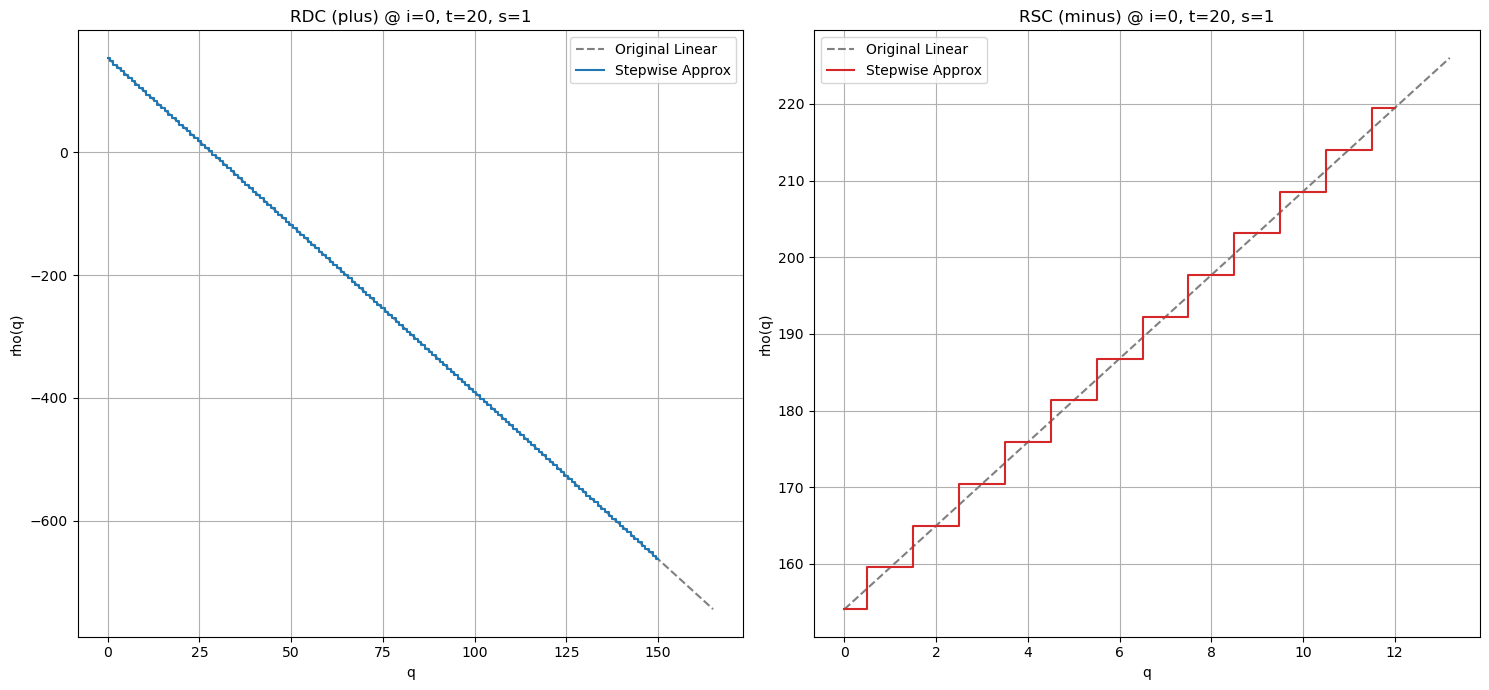

In [11]:
def plot_rho_stepwise_list(rho_plus, rho_minus, rho_plus_piece, rho_minus_piece, target_i, target_t, target_s):
    """
    [목적]
        - 선택된 (i, t, s)에 대해 선형 가격 함수와 stepwise 근사 결과를 함께 시각화

    [입력]
        rho_plus, rho_minus: 원본 선형 계수 (I, T, S, 2)
        rho_plus_piece, rho_minus_piece: 각 (i,t,s)별 계단형 근사 [q_b, p_b] 리스트
        target_i, target_t, target_s: 시각화할 대상 인덱스
    """

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    labels = ['RDC (plus)', 'RSC (minus)']
    colors = ['tab:blue', 'tab:red']
    rho_data = [rho_plus, rho_minus]
    pwl_data = [rho_plus_piece, rho_minus_piece]

    for idx, (rho, pwl_piece, ax, label, color) in enumerate(zip(
        rho_data, pwl_data, axes, labels, colors
    )):
        a, b = rho[target_i, target_t, target_s]
        piecewise = pwl_piece[target_i][target_t][target_s]  # shape (B, 2)
        q_vals = piecewise[:, 0]
        p_vals = piecewise[:, 1]

        # 원본 선형함수
        q_cont = np.linspace(0, max(q_vals) * 1.1 if np.any(q_vals > 0) else 1.0, 200)
        p_cont = a + b * q_cont
        ax.plot(q_cont, p_cont, '--', label='Original Linear', color='gray')

        # 계단형 근사
        ax.step(q_vals, p_vals, where='mid', label='Stepwise Approx', color=color)

        ax.set_title(f"{label} @ i={target_i}, t={target_t}, s={target_s}")
        ax.set_xlabel("q")
        ax.set_ylabel("rho(q)")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_rho_stepwise_list(
    rho_plus, rho_minus, 
    rho_plus_piece, rho_minus_piece, 
    target_i=0, target_t=20, target_s=1
    )

### Stepwise Model

In [12]:
x_part, yp_part, ym_part, z_part, zc_part, zd_part, dp_part, dm_part, up_part, um_part, wp_part, wm_part = [], [], [], [], [], [], [], [], [], [], [], []
model_part = []

for target_i in tqdm(range(I), desc="Optimizing PWL for each target_i"):
    # === 모델 생성 ===
    model = gp.Model("PWL_Internal_Optimization_{target_i}")
    model.setParam("OutputFlag", 0)
    model.setParam("MIPGap", 1e-7)

    # === 변수 정의 ===
    x = model.addVars(T, vtype=GRB.CONTINUOUS, lb=0, name="x")
    yp = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
    ym = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
    z = model.addVars(T+1, S, vtype=GRB.CONTINUOUS, lb=0, name="z")
    zc = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="z_charge")
    zd = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="z_discharge")
    dp = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="d_plus")
    dm = model.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="d_minus")

    p1  = model.addVars(T, S, vtype=GRB.BINARY, name="p1")
    p2  = model.addVars(T, S, vtype=GRB.BINARY, name="p2")
    p3  = model.addVars(T, S, vtype=GRB.BINARY, name="p3")
    p4  = model.addVars(T, S, vtype=GRB.BINARY, name="p4")
    p5  = model.addVars(T, S, vtype=GRB.BINARY, name="p5")
    p6  = model.addVars(T, S, vtype=GRB.BINARY, name="p6")
    p7  = model.addVars(T, S, vtype=GRB.BINARY, name="p7")
    p8  = model.addVars(T, S, vtype=GRB.BINARY, name="p8")

    # Stepwise variables
    wp, up = {}, {}
    wm, um = {}, {}

    for t in range(T):
        for s in range(S):
            Bp = B_map_plus[target_i, t, s]
            Bm = B_map_minus[target_i, t, s]
            for b in range(Bp):
                wp[t, s, b] = model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"w_plus_{t}_{s}_{b}")
                up[t, s, b] = model.addVar(vtype=GRB.BINARY, name=f"u_plus_{t}_{s}_{b}")
            for b in range(Bm):
                wm[t, s, b] = model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"w_minus_{t}_{s}_{b}")
                um[t, s, b] = model.addVar(vtype=GRB.BINARY, name=f"u_minus_{t}_{s}_{b}")

    model.update()

    # === 목적함수 정의 ===
    obj = gp.quicksum(P_DA[t] * x[t] for t in range(T)) \
        + gp.quicksum((1/S) * (P_RT[t, s] * yp[t, s] - P_PN[t] * ym[t, s]) for t in range(T) for s in range(S)) \
        + gp.quicksum((1/S) * (
            gp.quicksum(
                rho_plus_piece[target_i][t][s][b][1] * (wp[t, s, b] + up[t, s, b] * rho_plus_piece[target_i][t][s][b][0])
                for b in range(B_map_plus[target_i, t, s])
            ) -
            gp.quicksum(
                rho_minus_piece[target_i][t][s][b][1] * (wm[t, s, b] + um[t, s, b] * rho_minus_piece[target_i][t][s][b][0])
                for b in range(B_map_minus[target_i, t, s])
            )
        ) for t in range(T) for s in range(S))

    model.setObjective(obj, GRB.MAXIMIZE)

    # === 제약식 ===
    for t, s in product(range(T), range(S)):
        # 기본 수지식
        model.addConstr(R[target_i, t, s] - x[t] == yp[t, s] - ym[t, s] + zc[t, s] - zd[t, s] + dp[t, s] - dm[t, s])
        model.addConstr(yp[t, s] + dp[t, s] + zc[t, s] <= R[target_i, t, s] + zd[t, s])
        model.addConstr(z[t+1, s] == z[t, s] + zc[t, s] - zd[t, s])
        model.addConstr(zd[t, s] <= z[t, s])
        model.addConstr(zc[t, s] <= K[target_i] - z[t, s])
        model.addConstr(z[t, s] <= K[target_i])
        model.addConstr(z[t, s] >= 0)
        model.addConstr(yp[t, s] <= M1 * p1[t, s])
        model.addConstr(ym[t, s] <= M1 * (1 - p1[t, s]))
        model.addConstr(ym[t, s] <= M1 * p2[t, s])
        model.addConstr(zc[t, s] <= M1 * (1 - p2[t, s]))
        model.addConstr(zc[t, s] <= M1 * p3[t, s])
        model.addConstr(zd[t, s] <= M1 * (1 - p3[t, s]))
        model.addConstr(dp[t, s] <= M1 * p4[t, s])
        model.addConstr(dm[t, s] <= M1 * (1 - p4[t, s]))
        # model.addConstr(ym[t, s] <= M1 * p5[t, s])
        # model.addConstr(dp[t, s] <= M1 * (1 - p5[t, s]))
        # model.addConstr(yp[t, s] <= M1 * p6[t, s])
        # model.addConstr(dm[t, s] <= M1 * (1 - p6[t, s]))
        # model.addConstr(zc[t, s] <= M1 * p7[t, s])
        # model.addConstr(dm[t, s] <= M1 * (1 - p7[t, s]))
        # model.addConstr(zd[t, s] <= M1 * p8[t, s])
        # model.addConstr(dp[t, s] <= M1 * (1 - p8[t, s]))

        # piecewise aggregation
        model.addConstr(dp[t, s] == gp.quicksum(wp[t, s, b] + up[t, s, b] * rho_plus_piece[target_i][t][s][b][0]
                                                for b in range(B_map_plus[target_i, t, s])))
        model.addConstr(dm[t, s] == gp.quicksum(wm[t, s, b] + um[t, s, b] * rho_minus_piece[target_i][t][s][b][0]
                                                for b in range(B_map_minus[target_i, t, s])))

        model.addConstr(gp.quicksum(up[t, s, b] for b in range(B_map_plus[target_i, t, s])) <= 1)
        model.addConstr(gp.quicksum(um[t, s, b] for b in range(B_map_minus[target_i, t, s])) <= 1)

        # for b in range(B_map_plus[target_i, t, s]):
        #     width = rho_plus_piece[target_i][t][s][b][0]
        #     model.addConstr(w_plus[t, s, b] <= u_plus[t, s, b] * width)
        # for b in range(B_map_minus[target_i, t, s]):
        #     width = rho_minus_piece[target_i][t][s][b][0]
        #     model.addConstr(w_minus[t, s, b] <= u_minus[t, s, b] * width)
            
        for b in range(B_map_plus[target_i, t, s]):
            if b < B_map_plus[target_i, t, s] - 1:
                width = rho_plus_piece[target_i][t][s][b + 1][0] - rho_plus_piece[target_i][t][s][b][0]
            else:
                width = 1e-6 
            model.addConstr(wp[t, s, b] <= up[t, s, b] * width)

        for b in range(B_map_minus[target_i, t, s]):
            if b < B_map_minus[target_i, t, s] - 1:
                width = rho_minus_piece[target_i][t][s][b + 1][0] - rho_minus_piece[target_i][t][s][b][0]
            else:
                width = 1e-6
            model.addConstr(wm[t, s, b] <= um[t, s, b] * width)

    # 초기 상태
    for s in range(S):
        model.addConstr(z[0, s] == K0[target_i])

    model.optimize()
    model_part.append(model)

    x_part.append(np.array([x[t].X for t in range(T)]))
    yp_part.append(np.array([[yp[t, s].X for s in range(S)] for t in range(T)]))
    ym_part.append(np.array([[ym[t, s].X for s in range(S)] for t in range(T)]))
    z_part.append(np.array([[z[t, s].X for s in range(S)] for t in range(T+1)]))
    zc_part.append(np.array([[zc[t, s].X for s in range(S)] for t in range(T)]))
    zd_part.append(np.array([[zd[t, s].X for s in range(S)] for t in range(T)]))
    dp_part.append(np.array([[dp[t, s].X for s in range(S)] for t in range(T)]))
    dm_part.append(np.array([[dm[t, s].X for s in range(S)] for t in range(T)]))
    
    max_Bp = np.max(B_map_plus[target_i])
    max_Bm = np.max(B_map_minus[target_i])

    up_array = np.zeros((T, S, max_Bp))
    um_array = np.zeros((T, S, max_Bm))
    wp_array = np.zeros((T, S, max_Bp))
    wm_array = np.zeros((T, S, max_Bm))

    for t in range(T):
        for s in range(S):
            Bp = B_map_plus[target_i, t, s]
            Bm = B_map_minus[target_i, t, s]
            for b in range(Bp):
                up_array[t, s, b] = up[t, s, b].X
                wp_array[t, s, b] = wp[t, s, b].X
            for b in range(Bm):
                um_array[t, s, b] = um[t, s, b].X
                wm_array[t, s, b] = wm[t, s, b].X

    up_part.append(up_array)
    um_part.append(um_array)
    wp_part.append(wp_array)
    wm_part.append(wm_array)

Optimizing PWL for each target_i: 100%|██████████| 5/5 [00:29<00:00,  5.89s/it]


In [13]:
rho_plus_cleared = np.full((I, T, S), np.nan)
rho_minus_cleared = np.full((I, T, S), np.nan)

for target_i in range(I):
    for s, t in product(range(S), range(T)):
        Bp = B_map_plus[target_i, t, s]
        for bp in range(Bp):
            if round(up_part[target_i][t, s, bp]) == 1:
                rho_plus_cleared[target_i, t, s] = rho_plus_piece[target_i][t][s][bp][1]
                # print(f"[i={target_i}, t={t}, s={s}] bp={bp}, price={rho_plus_piece[target_i][t][s][bp][1]}, quantity={dp_part[target_i][t, s]} (D_min={rho_plus_piece[target_i][t][s][bp][0]} + w={wp_part[target_i][t, s, bp]})")
                break

        Bm = B_map_minus[target_i, t, s]
        for bm in range(Bm):
            if round(um_part[target_i][t, s, bm]) == 1:
                rho_minus_cleared[target_i, t, s] = rho_minus_piece[target_i][t][s][bm][1]
                # print(f"[i={target_i}, t={t}, s={s}] bm={bm}, price={rho_minus_piece[target_i][t][s][bm][1]}, quantity={dm_part[target_i][t, s]} (D_min={rho_minus_piece[target_i][t][s][bm][0]} + w={wm_part[target_i][t, s, bm]})")
                break

### Results

In [14]:
target_i = 0  # 원하는 인덱스로 바꿔서 사용

header = (
    f"{'s':>2} {'t':>2} | "
    f"{'R':>8} {'x':>8} {'y+':>8} {'y-':>8} "
    f"{'d+':>8} {'d-':>8} {'zc':>8} {'zd':>8} {'z':>8}\n"
    + "-" * 90
)
print(header)

for s, t in product(range(3, 4), range(T)):
    print(
        f"{s:>2} {t:>2} | "
        f"{R[target_i, t, s]:>8.2f} {x_part[target_i][t]:>8.2f} {yp_part[target_i][t, s]:>8.2f} {ym_part[target_i][t, s]:>8.2f} "
        f"{dp_part[target_i][t, s]:>8.2f} {dm_part[target_i][t, s]:>8.2f} {zc_part[target_i][t, s]:>8.2f} {zd_part[target_i][t, s]:>8.2f} {z_part[target_i][t, s]:>8.2f}"
    )

 s  t |        R        x       y+       y-       d+       d-       zc       zd        z
------------------------------------------------------------------------------------------
 3  0 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 3  1 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 3  2 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 3  3 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 3  4 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 3  5 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 3  6 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 3  7 |     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
 3  8 |    27.00     0.00     0.00     0.00     0.00     0.00    27.00     0.00     0.00
 3  9 |     1.00   

In [15]:
df_rho_cleared = pd.DataFrame([
    {
        "i": target_i,
        "t": t,
        "s": s,
        "": "|", 
        "RT": P_RT[t, s],
        "yp": yp_part[target_i][t, s],
        "rho_plus": rho_plus_cleared[target_i, t, s],
        "dp": dp_part[target_i][t, s],
        ".": "|", 
        "PN": P_PN[t],
        "ym": ym_part[target_i][t, s],
        "rho_minus": rho_minus_cleared[target_i, t, s],
        "dm": dm_part[target_i][t, s]
    }
    for s in range(3, 4)
    for t in range(T)
])

pd.DataFrame(df_rho_cleared)

,i,t,s,,RT,yp,rho_plus,dp,.,PN,ym,rho_minus,dm
0,0,0,3,|,73.184,0.000,-1000000000000000.000,0.000,|,148.649,0.000,1000000000000000.000,0.000
1,0,1,3,|,80.561,0.000,-1000000000000000.000,0.000,|,129.714,0.000,1000000000000000.000,0.000
2,0,2,3,|,67.196,0.000,-1000000000000000.000,0.000,|,119.828,0.000,1000000000000000.000,0.000
3,0,3,3,|,62.866,0.000,-1000000000000000.000,0.000,|,115.557,0.000,1000000000000000.000,0.000
4,0,4,3,|,69.720,0.000,-1000000000000000.000,0.000,|,115.226,0.000,1000000000000000.000,0.000
5,0,5,3,|,75.905,0.000,-1000000000000000.000,0.000,|,119.710,0.000,1000000000000000.000,0.000
6,0,6,3,|,71.152,0.000,-1000000000000000.000,0.000,|,130.299,0.000,1000000000000000.000,0.000
7,0,7,3,|,74.767,0.000,-1000000000000000.000,0.000,|,142.526,0.000,1000000000000000.000,0.000
8,0,8,3,|,89.380,0.000,-1000000000000000.000,0.000,|,170.099,0.000,1000000000000000.000,0.000
9,0,9,3,|,124.350,0.000,-1000000000000000.000,0.000,|,184.061,0.000,1000000000000000.000,0.000


In [16]:
# # === 시나리오 인덱스 지정 ===
# target_s = 3  # 분석할 시나리오 번호

# # === PWL 결과 합산 ===
# x_pwl_sum  = np.sum(np.array(x_part), axis=0)               # shape: (T,)
# yp_pwl_sum = np.sum(np.array(yp_part), axis=0)              # shape: (T, S)
# ym_pwl_sum = np.sum(np.array(ym_part), axis=0)              # shape: (T, S)
# dp_pwl_sum = np.sum(np.array(dp_part), axis=0)              # shape: (T, S)
# dm_pwl_sum = np.sum(np.array(dm_part), axis=0)              # shape: (T, S)

# # === set vs. 전체 PWL 결과 비교 출력 ===
# print(f"=== [시나리오 {target_s}] set 모델 vs 전체 PWL 결과 비교 ===\n")
# print(f"{'t':>2} | {'a_opt':>10} {'x_pwl_sum':>10} || {'bp_opt':>10} {'yp_pwl':>10} || {'bm_opt':>10} {'ym_pwl':>10} || {'dp_opt':>10} {'dp_pwl':>10} || {'dm_opt':>10} {'dm_pwl':>10}")
# print("-" * 120)

# for t in range(T):
#     a_ = a_opt[t]
#     x_ = x_pwl_sum[t]

#     bp_ = bp_opt[t][target_s]
#     yp_ = yp_pwl_sum[t, target_s]

#     bm_ = bm_opt[t][target_s]
#     ym_ = ym_pwl_sum[t, target_s]

#     dp_ = dp_opt[:, t, target_s].sum()
#     dpp_ = dp_pwl_sum[t, target_s]

#     dm_ = dm_opt[:, t, target_s].sum()
#     dmm_ = dm_pwl_sum[t, target_s]

#     print(f"{t:>2} | {a_:>10.3f} {x_:>10.3f} || {bp_:>10.3f} {yp_:>10.3f} || {bm_:>10.3f} {ym_:>10.3f} || {dp_:>10.3f} {dpp_:>10.3f} || {dm_:>10.3f} {dmm_:>10.3f}")

# # === 시나리오 기반 objective 비교 ===
# pwl_obj_external = sum(
#     P_DA[t] * x_pwl_sum[t] +
#     P_RT[t, target_s] * yp_pwl_sum[t, target_s] -
#     P_PN[t] * ym_pwl_sum[t, target_s]
#     for t in range(T)
# )
# print(f"\nset.objVal: {set.objVal:.6f}")
# print(f"PWL External Obj (scenario {target_s}): {pwl_obj_external:.6f}\n")

# # === target_i 기준, PWL+without 합산 비교 ===
# print(f"=== [시나리오 {target_s}] PWL(target_i) + without(target_i) vs set 모델 비교 ===\n")
# print(f"{'t':>2} | {'a_opt':>10} {'x_sum':>10} || {'bp_opt':>10} {'yp_sum':>10} || {'bm_opt':>10} {'ym_sum':>10} || {'dp_opt':>10} {'dp_sum':>10} || {'dm_opt':>10} {'dm_sum':>10}")
# print("-" * 120)

# for t in range(T):
#     a_ = a_opt[t]
#     x_ = x_part[target_i][t] + x_without[target_i][:, t].sum()

#     bp_ = bp_opt[t][target_s]
#     yp_ = yp_part[target_i][t, target_s] + ep_without[target_i][:, t, target_s].sum()

#     bm_ = bm_opt[t][target_s]
#     ym_ = ym_part[target_i][t, target_s] + em_without[target_i][:, t, target_s].sum()

#     dp_ = dp_opt[:, t, target_s].sum()
#     dpp_ = dp_part[target_i][t, target_s] + dp_without[target_i][:, t, target_s].sum()

#     dm_ = dm_opt[:, t, target_s].sum()
#     dmm_ = dm_part[target_i][t, target_s] + dm_without[target_i][:, t, target_s].sum()

#     print(f"{t:>2} | {a_:>10.3f} {x_:>10.3f} || {bp_:>10.3f} {yp_:>10.3f} || {bm_:>10.3f} {ym_:>10.3f} || {dp_:>10.3f} {dpp_:>10.3f} || {dm_:>10.3f} {dmm_:>10.3f}")

# # === 해당 시나리오 objective 비교 ===
# pwl_obj_external = 0.0
# for t in range(T):
#     x_sum = x_part[target_i][t] + x_without[target_i][:, t].sum()
#     yp_sum = yp_part[target_i][t, target_s] + ep_without[target_i][:, t, target_s].sum()
#     ym_sum = ym_part[target_i][t, target_s] + em_without[target_i][:, t, target_s].sum()

#     ext_profit = (
#         P_DA[t] * x_sum +
#         P_RT[t, target_s] * yp_sum -
#         P_PN[t] * ym_sum
#     )
#     pwl_obj_external += ext_profit

# print(f"\nset.objVal: {set.objVal:.6f}")
# print(f"PWL+Without External Obj (scenario {target_s}): {pwl_obj_external:.6f}")

# print(f"=== [시나리오 {target_s}] PWL(target_i) + without(target_i) vs set 모델 비교 ===\n")
# print(f"{'t':>2} | {'a_opt':>10} {'x_pwl':>10} {'x_wo':>10} {'x_sum':>10} || "
#       f"{'bp':>10} {'yp_pwl':>10} {'ep_wo':>10} {'yp_sum':>10} || "
#       f"{'bm':>10} {'ym_pwl':>10} {'em_wo':>10} {'ym_sum':>10} || "
#       f"{'dp':>10} {'dp_pwl':>10} {'d_wo':>10} {'dp_sum':>10} || "
#       f"{'dm':>10} {'dm_pwl':>10} {'d_wo':>10} {'dm_sum':>10}")
# print("-" * 200)

# for t in range(T):
#     a_ = a_opt[t]

#     x1 = x_part[target_i][t]
#     x2 = x_without[target_i][:, t].sum()
#     x_sum = x1 + x2

#     bp_ = bp_opt[t][target_s]
#     yp1 = yp_part[target_i][t, target_s]
#     yp2 = ep_without[target_i][:, t, target_s].sum()
#     yp_sum = yp1 + yp2

#     bm_ = bm_opt[t][target_s]
#     ym1 = ym_part[target_i][t, target_s]
#     ym2 = em_without[target_i][:, t, target_s].sum()
#     ym_sum = ym1 + ym2

#     dp_ = dp_opt[:, t, target_s].sum()
#     dp1 = dp_part[target_i][t, target_s]
#     dp2 = dp_without[target_i][:, t, target_s].sum()
#     dp_sum = dp1 + dp2

#     dm_ = dm_opt[:, t, target_s].sum()
#     dm1 = dm_part[target_i][t, target_s]
#     dm2 = dm_without[target_i][:, t, target_s].sum()
#     dm_sum = dm1 + dm2

#     print(f"{t:>2} | {a_:>10.3f} {x1:>10.3f} {x2:>10.3f} {x_sum:>10.3f} || "
#           f"{bp_:>10.3f} {yp1:>10.3f} {yp2:>10.3f} {yp_sum:>10.3f} || "
#           f"{bm_:>10.3f} {ym1:>10.3f} {ym2:>10.3f} {ym_sum:>10.3f} || "
#           f"{dp_:>10.3f} {dp1:>10.3f} {dp2:>10.3f} {dp_sum:>10.3f} || "
#           f"{dm_:>10.3f} {dm1:>10.3f} {dm2:>10.3f} {dm_sum:>10.3f}")

In [17]:
# === 시나리오 평균 기반 결과 합산 ===
x_pwl_sum  = np.sum(np.array(x_part), axis=0)                      # shape: (T,)
yp_pwl_avg = np.mean(np.sum(np.array(yp_part), axis=0), axis=1)    # shape: (T,)
ym_pwl_avg = np.mean(np.sum(np.array(ym_part), axis=0), axis=1)    # shape: (T,)
dp_pwl_avg = np.mean(np.sum(np.array(dp_part), axis=0), axis=1)    # shape: (T,)
dm_pwl_avg = np.mean(np.sum(np.array(dm_part), axis=0), axis=1)    # shape: (T,)

# === 시나리오 평균 기반 출력 ===
print(f"=== [시나리오 평균] set 모델 vs 전체 PWL 결과 비교 ===\n")
print(f"{'t':>2} | {'a_opt':>10} {'x_pwl_sum':>10} || {'bp_opt':>10} {'yp_avg':>10} || {'bm_opt':>10} {'ym_avg':>10} || {'dp_opt':>10} {'dp_avg':>10} || {'dm_opt':>10} {'dm_avg':>10}")
print("-" * 120)

for t in range(T):
    a_ = a_opt[t]
    x_ = x_pwl_sum[t]

    bp_ = np.mean(bp_opt[t])
    yp_ = yp_pwl_avg[t]

    bm_ = np.mean(bm_opt[t])
    ym_ = ym_pwl_avg[t]

    dp_ = np.mean(dp_opt[:, t, :].sum(axis=0))
    dpp_ = dp_pwl_avg[t]

    dm_ = np.mean(dm_opt[:, t, :].sum(axis=0))
    dmm_ = dm_pwl_avg[t]

    print(f"{t:>2} | {a_:>10.3f} {x_:>10.3f} || {bp_:>10.3f} {yp_:>10.3f} || {bm_:>10.3f} {ym_:>10.3f} || {dp_:>10.3f} {dpp_:>10.3f} || {dm_:>10.3f} {dmm_:>10.3f}")

# === Objective (scenario average) ===
pwl_obj_external = 0.0
for t in range(T):
    x_val = x_pwl_sum[t]
    yp_val = yp_pwl_avg[t]
    ym_val = ym_pwl_avg[t]

    avg_rt = np.mean(P_RT[t, :])
    ext_profit = P_DA[t] * x_val + avg_rt * yp_val - P_PN[t] * ym_val
    pwl_obj_external += ext_profit

print(f"\nset.objVal: {set.objVal:.6f}")
print(f"Average Scenario PWL External Obj: {pwl_obj_external:.6f}")

=== [시나리오 평균] set 모델 vs 전체 PWL 결과 비교 ===

 t |      a_opt  x_pwl_sum ||     bp_opt     yp_avg ||     bm_opt     ym_avg ||     dp_opt     dp_avg ||     dm_opt     dm_avg
------------------------------------------------------------------------------------------------------------------------
 0 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 1 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 2 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 3 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 4 |      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000 ||      0.000      0.000
 5 |      0.000      0.000 ||      0.050      0.050 ||      0.000      0.00

In [18]:
target_i=7
print(f"=== [시나리오 평균] set 모델 vs (PWL + without) 결과 비교 ===\n")
print(f"{'t':>2} | {'a_opt':>10} {'x_sum':>10} || {'bp_opt':>10} {'yp_avg':>10} || {'bm_opt':>10} {'ym_avg':>10} || {'dp_opt':>10} {'dp_avg':>10} || {'dm_opt':>10} {'dm_avg':>10}")
print("-" * 120)

for t in range(T):
    a_ = a_opt[t]
    x_ = x_part[target_i][t] + x_without[target_i][:, t].sum()

    bp_ = bp_opt[t, :].mean()
    yp_ = np.mean(yp_part[target_i][t, :] + ep_without[target_i][:, t, :].sum(axis=0))

    bm_ = bm_opt[t, :].mean()
    ym_ = np.mean(ym_part[target_i][t, :] + em_without[target_i][:, t, :].sum(axis=0))

    dp_ = np.mean(dp_opt[:, t, :].sum(axis=0))
    dpp_ = np.mean(dp_part[target_i][t, :] + dp_without[target_i][:, t, :].sum(axis=0))

    dm_ = np.mean(dm_opt[:, t, :].sum(axis=0))
    dmm_ = np.mean(dm_part[target_i][t, :] + dm_without[target_i][:, t, :].sum(axis=0))

    print(f"{t:>2} | {a_:>10.3f} {x_:>10.3f} || {bp_:>10.3f} {yp_:>10.3f} || {bm_:>10.3f} {ym_:>10.3f} || {dp_:>10.3f} {dpp_:>10.3f} || {dm_:>10.3f} {dmm_:>10.3f}")
    
# === External Objective (scenario average) ===
pwl_obj_external = 0.0
for t in range(T):
    x_val = x_part[target_i][t] + x_without[target_i][:, t].sum()
    yp_val = yp_part[target_i][t, :] + ep_without[target_i][:, t, :].sum(axis=0)
    ym_val = ym_part[target_i][t, :] + em_without[target_i][:, t, :].sum(axis=0)

    avg_rt = np.mean(P_RT[t, :])
    ext_profit = P_DA[t] * x_val + avg_rt * np.mean(yp_val) - P_PN[t] * np.mean(ym_val)
    pwl_obj_external += ext_profit

print(f"\nset.objVal: {set.objVal:.6f}")
print(f"Average Scenario (PWL + without) External Obj: {pwl_obj_external:.6f}")

=== [시나리오 평균] set 모델 vs (PWL + without) 결과 비교 ===

 t |      a_opt      x_sum ||     bp_opt     yp_avg ||     bm_opt     ym_avg ||     dp_opt     dp_avg ||     dm_opt     dm_avg
------------------------------------------------------------------------------------------------------------------------


IndexError: list index out of range

In [50]:
print(f"=== [시나리오 평균] PWL(target_i) + without(target_i) vs set 모델 비교 ===\n")
print(f"{'t':>2} | {'a_opt':>10} {'x_pwl':>10} {'x_wo':>10} {'x_sum':>10} || "
      f"{'bp_avg':>10} {'yp_pwl':>10} {'ep_wo':>10} {'yp_sum':>10} || "
      f"{'bm_avg':>10} {'ym_pwl':>10} {'em_wo':>10} {'ym_sum':>10} || "
      f"{'dp_avg':>10} {'dp_pwl':>10} {'d_wo':>10} {'dp_sum':>10} || "
      f"{'dm_avg':>10} {'dm_pwl':>10} {'d_wo':>10} {'dm_sum':>10}")
print("-" * 200)

for t in range(T):
    a_ = a_opt[t]
    x_pwl = x_part[target_i][t]
    x_wo = x_without[target_i][:, t].sum()
    x_sum = x_pwl + x_wo

    bp_avg = bp_opt[t, :].mean()
    yp_pwl = np.mean(yp_part[target_i][t, :])
    ep_wo = np.mean(ep_without[target_i][:, t, :].sum(axis=0))
    yp_sum = yp_pwl + ep_wo

    bm_avg = bm_opt[t, :].mean()
    ym_pwl = np.mean(ym_part[target_i][t, :])
    em_wo = np.mean(em_without[target_i][:, t, :].sum(axis=0))
    ym_sum = ym_pwl + em_wo

    dp_avg = np.mean(dp_opt[:, t, :].sum(axis=0))
    dp_pwl = np.mean(dp_part[target_i][t, :])
    d_wo = np.mean(dp_without[target_i][:, t, :].sum(axis=0))
    dp_sum = dp_pwl + d_wo

    dm_avg = np.mean(dm_opt[:, t, :].sum(axis=0))
    dm_pwl = np.mean(dm_part[target_i][t, :])
    d_wo_m = np.mean(dm_without[target_i][:, t, :].sum(axis=0))
    dm_sum = dm_pwl + d_wo_m

    print(f"{t:>2} | {a_:>10.3f} {x_pwl:>10.3f} {x_wo:>10.3f} {x_sum:>10.3f} || "
          f"{bp_avg:>10.3f} {yp_pwl:>10.3f} {ep_wo:>10.3f} {yp_sum:>10.3f} || "
          f"{bm_avg:>10.3f} {ym_pwl:>10.3f} {em_wo:>10.3f} {ym_sum:>10.3f} || "
          f"{dp_avg:>10.3f} {dp_pwl:>10.3f} {d_wo:>10.3f} {dp_sum:>10.3f} || "
          f"{dm_avg:>10.3f} {dm_pwl:>10.3f} {d_wo_m:>10.3f} {dm_sum:>10.3f}")

=== [시나리오 평균] PWL(target_i) + without(target_i) vs set 모델 비교 ===

 t |      a_opt      x_pwl       x_wo      x_sum ||     bp_avg     yp_pwl      ep_wo     yp_sum ||     bm_avg     ym_pwl      em_wo     ym_sum ||     dp_avg     dp_pwl       d_wo     dp_sum ||     dm_avg     dm_pwl       d_wo     dm_sum
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 0 |      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000
 1 |      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000 ||      0.000      0.000      0.000      0.000
 2 |      0.000      0